# Agriculture Report

In [2]:
import Input_template
from Input_template import *

In [5]:
## boundary files
district_boundary = "workdir/extra_inputs/shp_district/shp_district.shp"
village = "workdir/extra_inputs/shp_settlement/shp_settlement.shp"
taluk = "workdir/extra_inputs/shp_taluk/shp_taluk.shp"
## module files
theoritical = "workdir/agri/shp_agri_theo/shp_agri_theo.shp"
technical ="workdir/agri/shp_agri_tech/shp_agri_tech.shp"
high = "workdir/agri/shp_agri_high/shp_agri_high.shp"
med  = "workdir/agri/shp_agri_med/shp_agri_med.shp"
## other module high files
water_high = "workdir/water/shp_water_high/shp_water_high.shp"
forest_high = "workdir/forest/shp_forest_high/shp_forest_high.shp"
housing_high = "workdir/housing/shp_housing_high/shp_housing_high.shp"
solar_high = "workdir/solar/shp_solar_high/shp_solar_high.shp"
industry_high = "workdir/industry/shp_industry_high/shp_industry_high.shp"
Unused_land = "workdir/extra_inputs/Unused/Unused.shp"
## landcover shape files
Unused_land = "workdir/extra_inputs/Unused/Unused.shp" 
Sparseveg = "workdir/extra_inputs/shp_sparseveg/shp_sparseveg.shp"
Cropland = "workdir/extra_inputs/shp_cropland/shp_cropland.shp"
Forest = "workdir/extra_inputs/shp_forest/shp_forest.shp"
waterbodies = "workdir/extra_inputs/shp_water_bodies/shp_water_bodies.shp"
urban ="workdir/extra_inputs/shp_builtup/shp_builtup.shp"
access ="workdir/extra_inputs/shp_access/shp_access.shp"
## dist by size
S1 = "workdir/agri/S1/S1.shp"
S2 = "workdir/agri/S2/S2.shp"
S3 ="workdir/agri/S3/S3.shp"
## extra inputs
slope =get_rooted("workdir/raster/slope.tif")
shp_soil_erosion = read_df_UT("workdir/agri/soil_erosion/soil_erosion.shp")

In [7]:
## boundary files
shp_district = read_df_UT(district_boundary)
shp_village = read_df_UT(village)
shp_taluk = read_df_UT(taluk)
## module files
shp_agri_theo = read_df_UT(theoritical)
shp_agri_tech = read_df_UT(technical)
shp_agri_high =read_df_UT(high)
shp_agri_med = read_df_UT(med)
## other module high files
shp_water_high = read_df_UT(water_high)
shp_forest_high = read_df_UT(forest_high)
shp_housing_high = read_df_UT(housing_high)
shp_solar_high = read_df_UT(solar_high)
shp_indus_high =read_df_UT(industry_high)
## landcover shape files
shp_unused = read_df_UT(Unused_land)
## dist by size
S1 = read_df_UT(S1)
S2 = read_df_UT(S2)
S3 = read_df_UT(S3)

In [12]:
shp_unused = add_area_and_class_agri(shp_unused)

## Report Tables

### Stats

In [13]:
def summarize_data(df, name):
    summary = df.groupby("area_class")["area_acres"].agg(["sum", "count"]).reset_index()
    summary.columns = ["area_class", f"{name}_sum", f"{name}_count"]
    return summary

data_frames = [shp_unused, shp_agri_theo, shp_agri_tech, shp_agri_high, shp_agri_med]
data_names = ['unused', 'theo', 'tech', 'high', 'med']

summary_dict = {}

for df, name in zip(data_frames, data_names):
    summary_dict[name] = summarize_data(df, name)

merged_summary = summary_dict['unused']
for name in data_names[1:]:
    merged_summary = pd.merge(merged_summary, summary_dict[name], on="area_class", how="outer")

merged_summary = merged_summary.fillna(0)
merged_summary

### Competing use (need to improve)

In [15]:
shp_agri_water= find_overlap(shp_agri_tech,"water",shp_water_high)
shp_agri_forest = find_overlap(shp_agri_tech,"forest",shp_forest_high)
shp_agri_housing =find_overlap(shp_agri_tech,"hsing",shp_housing_high)
shp_agri_indus =find_overlap(shp_agri_tech,"indus",shp_indus_high)
shp_agri_solar =find_overlap(shp_agri_tech,"solar",shp_solar_high)
combined = pd.concat([shp_indus_high,shp_forest_high,shp_water_high,shp_solar_high,shp_housing_high])
combined.reset_index(inplace =True,drop =True)
inter = gpd.overlay(shp_agri_tech,combined,how ="intersection",keep_geom_type=True)
inter = inter.dissolve()
inter = add_area_and_class(inter)
data = {
    'agri_forest': shp_agri_forest.oparforest.sum(),
    'agri_water': shp_agri_water.oparwater.sum(),
    'agri-housing':shp_agri_housing.oparhsing.sum(),
    'agri-indus': shp_agri_indus.oparindus.sum(),
    'agri-solar': shp_agri_solar.oparsolar.sum(),
    'Competing use':inter.area_acres.sum(),
}
competing_use = pd.DataFrame(data, index=[0])

In [18]:
competing_use

,agri_forest,agri_water,agri-housing,agri-indus,agri-solar,Competing use
0,3155.558195,101.680812,2149.112939,6243.141583,7557.534072,16435.798545


### Distribution by type

In [ ]:
S_list = [S1, S2, S3]

overlap_data = {}

land_use_categories = ['forest', 'water','hsing', 'indus','solar']
high_dataframes = [shp_forest_high, shp_water_high,shp_housing_high, shp_indus_high,shp_solar_high]


for idx, S in enumerate(S_list):
    S_op_dict = {}
    for category, high_df in zip(land_use_categories, high_dataframes):
        S_op_dict[category] = find_overlap(S, category, high_df)
    overlap_data[f"S{idx+1}"] = S_op_dict

data = []
for idx, S in enumerate(S_list):
    row_data = [
        overlap_data[f"S{idx+1}"]["forest"].oparforest.sum(),
        overlap_data[f"S{idx+1}"]["water"].oparwater.sum(),
        overlap_data[f"S{idx+1}"]["hsing"].oparhsing.sum(),
        overlap_data[f"S{idx+1}"]["indus"].oparindus.sum(),
        overlap_data[f"S{idx+1}"]["solar"].oparsolar.sum()
    ]
    data.append(row_data)

Dist_by_type = pd.DataFrame(data, columns=['Forest', 'Water', 'housing', 'industry','solar'], index=['S1', 'S2', 'S3'])

In [23]:
Dist_by_type

,Forest,Water,housing,indus,solar
S1,107.545102,24.351710,0.000000,1526.893640,3.478816
S2,193.245688,19.282578,286.952597,732.879022,5.069131
S3,2854.767404,58.046524,1862.160342,3983.368922,7548.986125


In [24]:
largest_plot = shp_agri_tech.area_acres.max()

In [25]:
largest_plot

1161.749158561814

## Soil erosion

### the correct results are in the bottom 

In [27]:
shp_soil_erosion.erosion_ca.value_counts()

moderately    17
slightly      13
severely       7
Name: erosion_ca, dtype: int64

In [28]:
shp_moderately = shp_soil_erosion[shp_soil_erosion["erosion_ca"] =="moderately"]
shp_slightly = shp_soil_erosion[shp_soil_erosion["erosion_ca"] =="slightly"]
shp_severely = shp_soil_erosion[shp_soil_erosion["erosion_ca"] =="severely"]

In [29]:
shp_soil_erosion = read_df_UT("workdir/agri/soil_erosion/soil_erosion.shp")

shp_agri_tech = read_df_UT(technical)

shp_soil_erosion = shp_soil_erosion[["erosion_ca","geometry"]]

shp_agri_tech = shp_agri_tech[["area_acres","geometry"]]

categories = shp_soil_erosion
lands = shp_agri_tech
lands["Category"] =""
# Loop through the joined data and assign categories
for index, row in lands.iterrows():
    for cat_index, cat_row in categories.iterrows():
        if row['geometry'].within(cat_row['geometry']):
            lands.at[index, 'Category'] = cat_row['erosion_ca']
            break
    else:
        lands.at[index, 'Category'] = 'Mixed'

lands.Category.value_counts().sum()

df = lands.groupby("Category")["area_acres"].agg(["sum", "count"])

df

,sum,count
Category,,
Mixed,30692.277421,1333
moderately,16944.883249,3167
severely,708.341770,157
slightly,31427.961137,5969


In [30]:
template = load_workbook(get_rooted('workdir/agri/agri_temp.xlsx'))
ws = template['Sheet1']

# Define the ranges where to insert the dataframes
ranges = ['A2:K5','A10:F10','B13:F15','B20:C23']

# Insert the dataframes into the workbook
for x, r in zip([merged_summary,competing_use,Dist_by_type,df], ranges):
    start_col, start_row, end_col, end_row = openpyxl.utils.cell.range_boundaries(r)
    for i, row in enumerate(x.values):
        for j, value in enumerate(row):
            ws.cell(row=start_row + i, column=start_col + j, value=value)
ws.cell(row=17, column=2, value=largest_plot)           
template.save(get_in_output('agri/agri_temp_filled.xlsx'))

## Top15

In [31]:
shp_agri_high_sorted = shp_agri_high.sort_values(by=["area_acres"],ascending = False)
shp_agri_top15  = shp_agri_high_sorted[:15]
shp_agri_top15.reset_index(inplace =True)

In [33]:
df = shp_agri_top15
slope =get_rooted("workdir/raster/slope.tif")
top15_agri = calculate_slope(df, slope)

C:\Users\User\anaconda1\envs\lila\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [34]:
top15_agri['coords'] = top15_agri['geometry'].apply(lambda x: x.representative_point().coords[:])
top15_agri['coords'] = [coords[0] for coords in top15_agri['coords']]
top15_agri["coords"].tolist()
top15_agri[['lat', 'lon']] = gpd.GeoDataFrame(top15_agri['coords'].tolist(), index=top15_agri.index) 

In [35]:
overlap = find_overlap(top15_agri,"solar",shp_solar_high)
overlap = find_overlap(overlap,"forest",shp_forest_high)
overlap = find_overlap(overlap,"water",shp_water_high)
overlap = find_overlap(overlap,"hsing",shp_housing_high)
overlap = find_overlap(overlap,"indus",shp_indus_high)

In [36]:
overlap.columns

Index(['index', 'gid', 'dist_name', 'ed_distric', 'drd_dcode', 'drddcode',
       'dist_mmm', 'cen_dcode2', 'cen_dcod_1', 'cen_dcode', 'dcode',
       'district', 'district_t', 'Unnamed_ 0', 'LandClass', 'area_sqkm',
       'wtmindist', 'wtdist', 'erosion_cl', 'descriptio', 'DISTRICT_1',
       'STATE', 'area_acres', 'area_class', 'Index', 'geometry', 'min', 'max',
       'mean', '25percentile', '75percentile', 'coords', 'lat', 'lon',
       'op%solar', 'oparsolar', 'cntsolar', 'op%forest', 'oparforest',
       'cntforest', 'op%water', 'oparwater', 'cntwater', 'op%hsing',
       'oparhsing', 'cnthsing', 'op%indus', 'oparindus', 'cntindus'],
      dtype='object')

In [37]:
overlap.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 49 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   index         15 non-null     int64   
 1   gid           15 non-null     int64   
 2   dist_name     15 non-null     object  
 3   ed_distric    15 non-null     object  
 4   drd_dcode     0 non-null      object  
 5   drddcode      15 non-null     float64 
 6   dist_mmm      0 non-null      object  
 7   cen_dcode2    0 non-null      object  
 8   cen_dcod_1    0 non-null      object  
 9   cen_dcode     0 non-null      object  
 10  dcode         15 non-null     int64   
 11  district      15 non-null     object  
 12  district_t    15 non-null     object  
 13  Unnamed_ 0    15 non-null     object  
 14  LandClass     15 non-null     object  
 15  area_sqkm     15 non-null     float64 
 16  wtmindist     15 non-null     object  
 17  wtdist        15 non-null     object  
 18  eros

In [38]:
overlap.iloc[:,34:49] = overlap.iloc[:,34:49].astype(float)

C:\Users\User\AppData\Local\Temp\ipykernel_3216\1929371287.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  overlap.iloc[:,34:49] = overlap.iloc[:,34:49].astype(float)


In [39]:
overlap_top15 = overlap[["lat","lon","area_acres","wtmindist","wtdist","erosion_cl","min","max",'op%solar', 'oparsolar',
       'cntsolar', 'op%forest', 'oparforest', 'cntforest', 'op%water',
       'oparwater', 'cntwater', 'op%hsing', 'oparhsing', 'cnthsing', 'op%indus',
       'oparindus', 'cntindus','geometry']]

In [40]:
overlap_top15.to_file(get_in_output("agri/Top15_final"))

In [41]:
overlap_top15_excel = overlap[["lat","lon","area_acres","wtmindist","wtdist","erosion_cl","min","max",'op%solar', 'oparsolar',
       'cntsolar', 'op%forest', 'oparforest', 'cntforest', 'op%water',
       'oparwater', 'cntwater', 'op%hsing', 'oparhsing', 'cnthsing', 'op%indus',
       'oparindus', 'cntindus']]

In [42]:
overlap_top15_excel.to_excel(get_in_output("agri/Top15_final.xlsx"))

# Visuals

## Technical Suitability - Technical, theoretical, and no potential lands

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

['Helvetica']


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


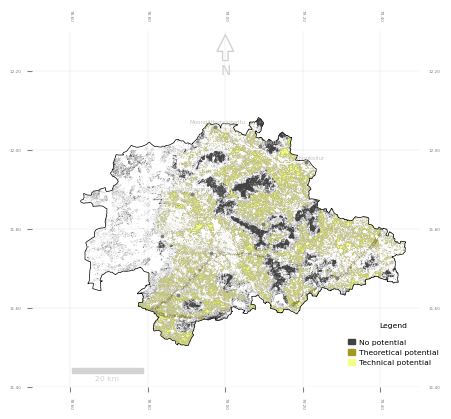

In [46]:
fig8, ax8 = plt.subplots(figsize=(5, 5))

plot_common_features(fig8, ax8)
plot_cities(fig8, ax8)


shp_district.plot(figsize=(5,5),color="none", ax=ax8, linewidth = 0.5, zorder=5)

shp_unused.plot(color="#424242",ax =ax8, label='No Potential')
shp_agri_theo.plot(color="#a09a22",ax =ax8, label='Theoretical Potential')
shp_agri_tech.plot(color="#f3ff8b",ax =ax8, label='Technical Potential')


No_P = mpatches.Patch(color='#424242', label='No potential')
Theo_P = mpatches.Patch(color='#a09a22', label='Theoretical potential')
Tech_P = mpatches.Patch(color='#f3ff8b', label='Technical potential')
    
plt.legend(handles = [No_P, Theo_P, Tech_P], loc = 'upper left', bbox_to_anchor=(0.8, 0.2), title = 'Legend\n', fontsize = 5.5, markerscale = 2, title_fontsize = 5.5, framealpha= 0, borderpad = 0.3, handletextpad = 0.5, handlelength = 1.0)


print(plt.rcParams['font.family'])


plt.savefig(get_in_output("images/agri/Technical_suitability.jpg"),dpi =1500)
plt.show()

## Distribution by type

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


['Helvetica']


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

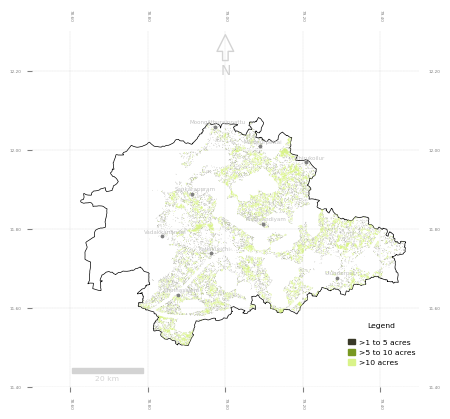

In [47]:
fig9, ax9 = plt.subplots(figsize=(5, 5))

plot_common_features(fig9, ax9)
plot_cities(fig9, ax9)


shp_district.plot(figsize=(5,5),color="none", ax=ax9, linewidth = 0.5)

S1.plot(color="#393928",ax =ax9, label='>1 to 5 acres')
S2.plot(color="#789821",ax =ax9, label='>5 to 10 acres')
S3.plot(color="#d9f389",ax =ax9, label='>10 acres')


S1 = mpatches.Patch(color='#393928', label='>1 to 5 acres')
S2 = mpatches.Patch(color='#789821', label='>5 to 10 acres')
S3 = mpatches.Patch(color='#d9f389', label='>10 acres')
    
plt.legend(handles = [S1, S2, S3], loc = 'upper left', bbox_to_anchor=(0.8, 0.2), title = 'Legend\n', fontsize = 5.5, markerscale = 2, title_fontsize = 5.5, framealpha= 0, borderpad = 0.3, handletextpad = 0.5, handlelength = 1.0)

print(plt.rcParams['font.family']);


plt.savefig(get_in_output("images/agri/Distribution by size.jpg"),dpi =1500)
plt.show()

## High Potential

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


['Helvetica']


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

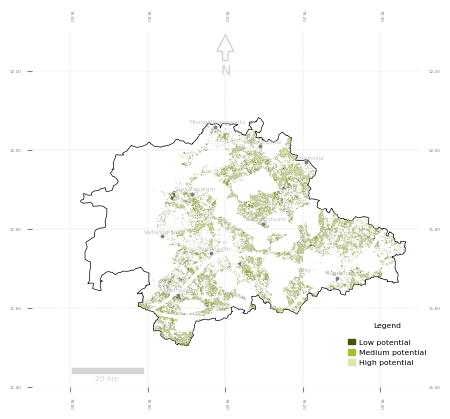

In [48]:
fig10, ax10 = plt.subplots(figsize=(5, 5))

plot_common_features(fig10, ax10)
plot_cities(fig10, ax10)

shp_district.plot(figsize=(5,5),color="none", ax=ax10, linewidth = 0.5, zorder= 1)

shp_agri_tech.plot(color="#4f4d0e",ax =ax10, label='Low Potential')
shp_agri_med.plot(color="#a6c12d",ax =ax10, label='Medium Potential')
shp_agri_high.plot(color="#dbe7a4",ax =ax10, label='High Potential')


Low_P = mpatches.Patch(color='#4f4d0e', label='Low potential')
Med_P = mpatches.Patch(color='#a6c12d', label='Medium potential')
High_P = mpatches.Patch(color='#dbe7a4', label='High potential')
    
plt.legend(handles = [Low_P, Med_P, High_P], loc = 'upper left', bbox_to_anchor=(0.8, 0.2), title = 'Legend\n', fontsize = 5.5, markerscale = 2, title_fontsize = 5.5, framealpha= 0, borderpad = 0.3, handletextpad = 0.5, handlelength = 1.0)

print(plt.rcParams['font.family'])


plt.savefig(get_in_output("images/agri/High Potential_H_M_L.jpg"),dpi =1500)
plt.show()

# Settlement analysis

In [50]:
popdf = pd.DataFrame()
for j in range(len(shp_village)):
    input_shp =  get_rooted('workdir/temp_agri.shp')

    selection = shp_village.geometry[j:j+1]
    if selection.geometry.is_empty.bool():
        rasterarr = []
    else:
        selection.to_file(input_shp)

        input_raster= get_rooted("workdir/raster/population_10_lon_70_general-v1.5.tif")

        output_raster = get_rooted('workdir/temp_agri.tif')
        ds = gdal.Warp(output_raster,
                      input_raster,
                      format = 'GTiff',
                      cutlineDSName = input_shp,
                      cropToCutline=True,
                      )
        ds = None

        raster = gdal.Open(output_raster, gdal.GA_ReadOnly)
        rasterarr = raster.ReadAsArray()
        #Set -9999 as no data values
        rasterarr = np.where(rasterarr==-9999, np.nan,rasterarr)
        #remove nodata values
        rasterarr = rasterarr[~np.isnan(rasterarr)]


    if (np.size(rasterarr)==0):
        popdf.at[j, "totpop"]=0


    else:    

        pop_sum = rasterarr.sum()

        popdf.at[j, "totpop"]=pop_sum

shp_village_final = pd.concat([shp_village, popdf], axis = 1)

In [51]:
shp_village_final.columns

Index(['gid', 'dist_name_', 'ed_distric', 'drd_dcode', 'drddcode_1',
       'dist_mmm_1', 'cen_dcode2', 'cen_dcod_1', 'cen_dcode', 'dcode',
       'district', 'district_t', 'ogc_fid', 'fid_1', 'p_name', 'd_name',
       'b_name', 'p_name_rd', 'pancha_id', 'block_id_o', 'dist_id',
       'district_r', 'gp_code', 'type1', 'phc', 'hsc', 'remarks', 'ip_address',
       'date_time', 'username', 'drddcode_2', 'block_id', 'ed_distr_1',
       'dist_blk_v', 'village_tn', 'lgd_dcode', 'lgd_vcode', 'census_dco',
       'census_pvc', 'dist_nam_1', 'dist_mmm_2', 'ed_distr_2', 'dist_bk_pv',
       'dist_blk', 'area_acres', 'area_class', 'geometry', 'totpop'],
      dtype='object')

In [52]:
shp_village_final.totpop.sum()

1542939.915713

In [53]:
shp_village_final['coords'] = shp_village_final['geometry'].apply(lambda x: x.representative_point().coords[:])
shp_village_final['coords'] = [coords[0] for coords in shp_village_final['coords']]
shp_village_final["coords"].tolist()
shp_village_final[['lat', 'lon']] = gpd.GeoDataFrame(shp_village_final['coords'].tolist(), index=shp_village_final.index) 

In [54]:
shp_village_final = shp_village_final.to_crs(32644)
shp_village_final["TGA(acres)"] = ((shp_village_final.geometry.area)/10**6)*247.105
shp_village_final = shp_village_final.to_crs(4326)

In [55]:
shp_village_tech = find_overlap(shp_village_final,"tech",shp_agri_tech)

In [56]:
# shp_village_tech =  find_overlap(shp_village_tech,"unused",shp_unused)

In [57]:
shp_village_tech = shp_village_tech.to_crs(4326)

In [58]:
shp_village_tech.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 55 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   gid         460 non-null    int64   
 1   dist_name_  460 non-null    object  
 2   ed_distric  460 non-null    object  
 3   drd_dcode   0 non-null      object  
 4   drddcode_1  460 non-null    float64 
 5   dist_mmm_1  0 non-null      object  
 6   cen_dcode2  0 non-null      object  
 7   cen_dcod_1  0 non-null      object  
 8   cen_dcode   0 non-null      object  
 9   dcode       460 non-null    int64   
 10  district    460 non-null    object  
 11  district_t  460 non-null    object  
 12  ogc_fid     460 non-null    int64   
 13  fid_1       460 non-null    int64   
 14  p_name      460 non-null    object  
 15  d_name      460 non-null    object  
 16  b_name      460 non-null    object  
 17  p_name_rd   460 non-null    object  
 18  pancha_id   460 non-null    object  
 19  

In [59]:
shp_village_tech = shp_village_tech.iloc[:, [14,15,16,17] + list(range(44, 55))]

In [60]:
shp_village_tech.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   p_name      460 non-null    object  
 1   d_name      460 non-null    object  
 2   b_name      460 non-null    object  
 3   p_name_rd   460 non-null    object  
 4   area_acres  460 non-null    float64 
 5   area_class  460 non-null    object  
 6   geometry    460 non-null    geometry
 7   totpop      460 non-null    float64 
 8   coords      460 non-null    object  
 9   lat         460 non-null    float64 
 10  lon         460 non-null    float64 
 11  TGA(acres)  460 non-null    float64 
 12  op%tech     460 non-null    object  
 13  opartech    460 non-null    object  
 14  cnttech     460 non-null    object  
dtypes: float64(5), geometry(1), object(9)
memory usage: 54.0+ KB


In [61]:
shp_village_tech.iloc[:,12:15] = shp_village_tech.iloc[:,12:15].astype(float)

C:\Users\User\AppData\Local\Temp\ipykernel_3216\2393764547.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  shp_village_tech.iloc[:,12:15] = shp_village_tech.iloc[:,12:15].astype(float)


In [62]:
shp_village_tech= shp_village_tech[['p_name', 'd_name', 'b_name', 'p_name_rd', 'area_acres', 'area_class'
       , 'totpop', 'lat', 'lon', 'TGA(acres)', 'op%tech',
       'opartech', 'cnttech','geometry']]

In [63]:
shp_village_tech.to_file(get_in_output("agri/settlement"))

In [64]:
shp_village_tech.columns

Index(['p_name', 'd_name', 'b_name', 'p_name_rd', 'area_acres', 'area_class',
       'totpop', 'lat', 'lon', 'TGA(acres)', 'op%tech', 'opartech', 'cnttech',
       'geometry'],
      dtype='object')

In [65]:
shp_village = shp_village_tech[['p_name', 'd_name', 'b_name', 'p_name_rd', 'area_acres', 'area_class',
       'totpop', 'lat', 'lon', 'TGA(acres)', 'op%tech', 'opartech', 'cnttech']]

In [66]:
shp_village.to_excel(get_in_output("agri/230517_settlement.xlsx"))

In [67]:
shp_village.sort_values("p_name",inplace =True)

C:\Users\User\AppData\Local\Temp\ipykernel_3216\2220424596.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shp_village.sort_values("p_name",inplace =True)


In [68]:
shp_village.reset_index(drop =True,inplace =True)

In [69]:
shp_village_tech.drop("geometry",axis =1,inplace =True)

C:\Users\User\AppData\Local\Temp\ipykernel_3216\181623506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shp_village_tech.drop("geometry",axis =1,inplace =True)


In [70]:
shp_village.to_excel(get_in_output("agri/230517_settlement_ordered.xlsx"))

# Settlement visuals

In [71]:
settlement = read_df_UT("output/agri/settlement/settlement.shp")

In [72]:
S3 = LinearSegmentedColormap.from_list('testCmap1', colors=["#fbfada", "#def399", "#c4d85e", "#7a8737", "#4f541e"], N=256)

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

0.0 50.95270931377119


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

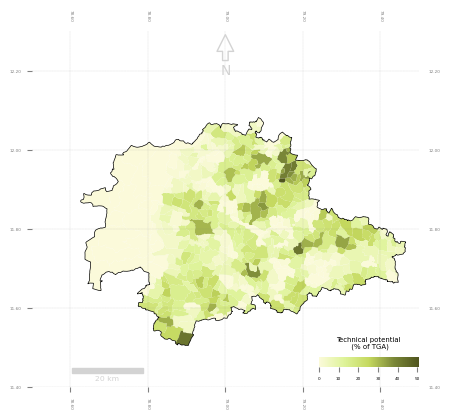

In [73]:

fig, ax = plt.subplots(figsize=(5, 5))

plot_common_features(fig, ax)  # assuming this function is defined elsewhere

shp_district.plot(figsize=(5,5), color="none", ax=ax, linewidth=0.5, zorder=5)
settlement.plot(column='op%tech', cmap=S3, ax=ax)
a = settlement["op%tech"].min()
b = settlement["op%tech"].max()
sm = plt.cm.ScalarMappable(cmap=S3)
cbaxes = fig.add_axes([0.7, 0.18, 0.2, 0.02]) 
cbar = plt.colorbar(sm, orientation = 'horizontal', cax=cbaxes, shrink = 0.2)
cbar.mappable.set_clim(vmin = a, vmax = b)
cbar.ax.tick_params(labelsize=3, color = 'grey')
cbar.outline.set_visible(False)
cbar.ax.set_title('Technical potential \n (% of TGA)', fontsize=5)

print(a,b)

plt.savefig(get_in_output("images/agri/Technical potential area(%).jpg"),dpi =1500)
plt.show()

### Taluk analysis

In [74]:
from shapely.geometry import shape

In [75]:
shp_taluk = "workdir/extra_inputs/shp_taluk/shp_taluk.shp"

In [76]:
shp_taluk = read_df_UT(shp_taluk)

In [77]:
shp_taluk = gpd.overlay(shp_district,shp_taluk,how="intersection")

In [78]:
# shp_taluk.to_file(get_in_workdir("extra_inputs/shp_taluk"))

In [79]:
popdf = pd.DataFrame()
for j in range(len(shp_taluk)):
    input_shp =  get_rooted('workdir/temp_t_h.shp')

    selection = shp_taluk.geometry[j:j+1]
    if selection.geometry.is_empty.bool():
        rasterarr = []
    else:
        selection.to_file(input_shp)

        input_raster= get_rooted("workdir/raster/population_10_lon_70_general-v1.5.tif")

        output_raster = get_rooted('workdir/temp_t_h.tif')
        ds = gdal.Warp(output_raster,
                      input_raster,
                      format = 'GTiff',
                      cutlineDSName = input_shp,
                      cropToCutline=True,
                      )
        ds = None

        raster = gdal.Open(output_raster, gdal.GA_ReadOnly)
        rasterarr = raster.ReadAsArray()
        #Set -9999 as no data values
        rasterarr = np.where(rasterarr==-9999, np.nan,rasterarr)
        #remove nodata values
        rasterarr = rasterarr[~np.isnan(rasterarr)]


    if (np.size(rasterarr)==0):
        popdf.at[j, "totpop"]=0


    else:    

        pop_sum = rasterarr.sum()

        popdf.at[j, "totpop"]=pop_sum

shp_taluk_final = pd.concat([shp_taluk, popdf], axis = 1)

In [80]:
shp_taluk_final

,gid,dist_name,ed_distric_1,drd_dcode,drddcode,dist_mmm,cen_dcode2_1,cen_dcod_1_1,cen_dcode,dcode,...,DIST_NAM_2,ED_DISTR_2,ED_TLKCODE,TALUK_ID,Taluk_name,ED_ET,area_acres,area_class,geometry,totpop
0,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,KALLAKURICHCHI,33,05,55,Tirukkoilur,3305,78895.642042,C,"POLYGON ((79.17153 12.03078, 79.17126 12.02987...",218029.273322
1,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,KALLAKURICHCHI,33,08,132,Sankarapuram,3308,190064.508278,C,"POLYGON ((78.83867 12.00942, 78.84236 12.00898...",385037.727314
2,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,KALLAKURICHCHI,33,06,193,Ulundurpet,3306,167191.536511,C,"POLYGON ((79.23269 11.87556, 79.23291 11.87538...",357441.695257
3,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,KALLAKURICHCHI,33,09,215,Chinna selam,3309,118604.211815,C,"POLYGON ((79.02235 11.60371, 79.02101 11.60421...",251918.640758
4,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,KALLAKURICHCHI,33,07,217,Kallakurichchi,3307,126664.229887,C,"MULTIPOLYGON (((79.19262 11.59780, 79.19235 11...",279356.543761
5,22,Kallakurichi,33,None,4.0,None,None,None,None,4,...,KALLAKURICHCHI,33,10,132,Kalvarayan Hills,3310,120179.034227,C,"POLYGON ((78.77955 11.70399, 78.77904 11.70370...",52533.918486


In [81]:
shp_taluk_final['coords'] = shp_taluk_final['geometry'].apply(lambda x: x.representative_point().coords[:])
shp_taluk_final['coords'] = [coords[0] for coords in shp_taluk_final['coords']]
shp_taluk_final["coords"].tolist()
shp_taluk_final[['lat', 'lon']] = gpd.GeoDataFrame(shp_taluk_final['coords'].tolist(), index=shp_taluk_final.index) 

In [82]:
shp_taluk_final = shp_taluk_final.to_crs(32644)
shp_taluk_final["TGA(acres)"] = ((shp_taluk_final.geometry.area)/10**6)*247.105
shp_taluk_final = shp_taluk_final.to_crs(4326)

In [83]:
shp_taluk_final = find_overlap(shp_taluk_final,"tech",shp_agri_tech)

In [84]:
# shp_taluk_final['geometry'] = shp_taluk_final['geometry'].apply(lambda x: shape(x).buffer(0).buffer(0.0000000000001))
# shp_taluk_finalshp_taluk_final = gpd.GeoDataFrame(shp_taluk_final, geometry='geometry')
# shp_taluk_final = shp_taluk_final.loc[shp_taluk_final.is_valid]

In [85]:
# shp_taluk_final =  find_overlap(shp_taluk_final,"unused",shp_unused)

In [86]:
shp_taluk_final = shp_taluk_final.to_crs(4326)

In [87]:
shp_taluk_final= shp_taluk_final[['Taluk_name', 'area_acres', 'area_class'
       , 'totpop', 'lat', 'lon', 'TGA(acres)', 'op%tech',
       'opartech', 'cnttech','geometry']]

In [88]:
shp_taluk_final.totpop.sum()

1544317.7988980003

In [89]:
shp_taluk_final.to_file(get_in_output("agri/shp_taluk"))

In [90]:
shp_taluk_final.drop("geometry",axis =1,inplace =True)

In [91]:
shp_taluk_final.to_excel(get_in_output("agri/taluk_analysis.xlsx"))

In [92]:
shp_taluk_final

,Taluk_name,area_acres,area_class,totpop,lat,lon,TGA(acres),op%tech,opartech,cnttech
0,Tirukkoilur,78895.642042,C,218029.273322,79.152376,11.963773,78895.642043,17.575605,13866.10545,1526
1,Sankarapuram,190064.508278,C,385037.727314,78.950819,11.909165,190064.508174,10.180529,19349.18156,2766
2,Ulundurpet,167191.536511,C,357441.695257,79.298605,11.738087,167191.536511,11.561526,19329.502374,2341
3,Chinna selam,118604.211815,C,251918.640758,78.840798,11.689243,118604.211970,10.125926,12009.531978,1918
4,Kallakurichchi,126664.229887,C,279356.543761,79.033884,11.693628,126664.230048,12.184219,15432.7344,2322
5,Kalvarayan Hills,120179.034227,C,52533.918486,78.749859,11.832063,120179.033848,0,0,0


In [93]:
# Create a new column that maps categories to specific colors
shp_soil_erosion['color'] = np.where(shp_soil_erosion['erosion_ca'] == 'slightly', '#fff4aa',
                       np.where(shp_soil_erosion['erosion_ca'] == 'moderately', '#ffd65a',
                                np.where(shp_soil_erosion['erosion_ca'] == 'severely', '#cb8b54', 'white')))

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

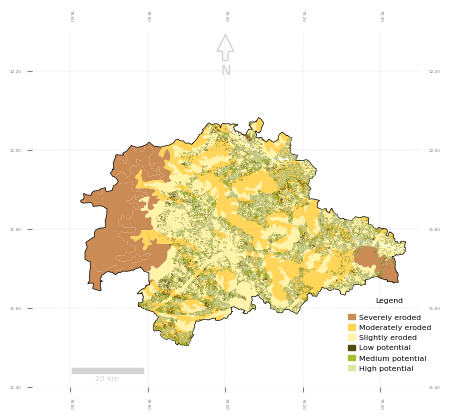

In [94]:

fig, ax = plt.subplots(figsize=(5, 5))

plot_common_features(fig, ax) 


shp_agri_tech.plot(figsize=(5,5),facecolor ="none",edgecolor="#4f4d0e" ,ax=ax, linewidth=0.1, zorder=7)
shp_agri_med.plot(figsize=(5,5),facecolor ="none",edgecolor="#a6c12d" ,ax=ax, linewidth=0.1, zorder=8)
shp_agri_high.plot(figsize=(5,5),facecolor ="none",edgecolor="#dbe7a4" ,ax=ax, linewidth=0.1, zorder=9)

shp_district.plot(figsize=(5,5), color="none", ax=ax, linewidth=0.5, zorder=5)
shp_soil_erosion.plot(color=shp_soil_erosion['color'], ax=ax)
Severely = mpatches.Patch(color="#cb8b54", label = 'Severely eroded')
Moderately = mpatches.Patch(color="#ffd65a", label = 'Moderately eroded')
Slightly= mpatches.Patch(color="#fff4aa", label = 'Slightly eroded')

Low_P = mpatches.Patch(color='#4f4d0e', label='Low potential')
Med_P = mpatches.Patch(color='#a6c12d', label='Medium potential')
High_P = mpatches.Patch(color='#dbe7a4', label='High potential')

plt.legend(handles = [Severely, Moderately, Slightly,Low_P,Med_P,High_P], loc = 'upper left', bbox_to_anchor=(0.8, 0.27), title = 'Legend\n', fontsize = 5.5, markerscale = 2, title_fontsize = 5.5, framealpha= 0, borderpad = 0.3, handletextpad = 0.5, handlelength = 1.0)
plt.savefig(get_in_output("images/agri/soil_erosion.jpg"),dpi =1500)
plt.show()

### Soil erosion stats

In [95]:
shp_soil_erosion = read_df_UT("workdir/agri/soil_erosion/soil_erosion.shp")

shp_agri_tech = read_df_UT(technical)

shp_soil_erosion = shp_soil_erosion[["erosion_ca","geometry"]]

shp_agri_tech = shp_agri_tech[["area_acres","geometry"]]

shp_soil_erosion["erosion_ca"].fillna("Others",inplace =True)

categories = shp_soil_erosion
lands = shp_agri_tech

lands["Category"] =""
# Loop through the joined data and assign categories
for index, row in lands.iterrows():
    for cat_index, cat_row in categories.iterrows():
        if row['geometry'].within(cat_row['geometry']):
            lands.at[index, 'Category'] = cat_row['erosion_ca']
            break
    else:
        lands.at[index, 'Category'] = 'Mixed'



df = lands.groupby("Category")["area_acres"].agg(["sum", "count"])

df

,sum,count
Category,,
Mixed,30692.277421,1333
Others,216.597769,75
moderately,16944.883249,3167
severely,708.341770,157
slightly,31427.961137,5969


In [96]:
df

,sum,count
Category,,
Mixed,30692.277421,1333
Others,216.597769,75
moderately,16944.883249,3167
severely,708.341770,157
slightly,31427.961137,5969


In [97]:
shp_soil_erosion = read_df_UT("workdir/agri/soil_erosion/soil_erosion.shp")

shp_agri_tech = read_df_UT(technical)

shp_soil_erosion = shp_soil_erosion[["erosion_ca","geometry"]]
shp_agri_tech = shp_agri_tech[["area_acres","geometry"]]

shp_soil_erosion["erosion_ca"].fillna("other", inplace=True)

In [98]:
shp_soil_erosion["erosion_ca"].value_counts()

moderately    17
slightly      13
severely       7
other          2
Name: erosion_ca, dtype: int64

In [99]:
shp_slightly = shp_soil_erosion[shp_soil_erosion["erosion_ca"] =="slightly"]
shp_slightly.reset_index(drop =True,inplace =True)
shp_moderately = shp_soil_erosion[shp_soil_erosion["erosion_ca"] =="moderately"]
shp_moderately.reset_index(drop =True,inplace =True)
shp_severely = shp_soil_erosion[shp_soil_erosion["erosion_ca"] =="severely"]
shp_severely.reset_index(drop =True,inplace =True)
shp_other = shp_soil_erosion[shp_soil_erosion["erosion_ca"] =="other"]
shp_other.reset_index(drop =True,inplace =True)

In [100]:
soil_eros_res = find_overlap(shp_agri_tech,"sl",shp_slightly)

In [101]:
soil_eros_res = find_overlap(soil_eros_res,"mo",shp_moderately)

In [102]:
soil_eros_res = find_overlap(soil_eros_res,"sv",shp_severely)

In [103]:
soil_eros_res = find_overlap(soil_eros_res,"ot",shp_other)

In [104]:
def get_category(soil_eros_res):
    if soil_eros_res['op%ot'] > 0:
        return 'Others'
    elif soil_eros_res['op%sl'] > 99:
        return 'slightly'
    elif soil_eros_res['op%mo'] > 99:
        return 'moderately'
    elif soil_eros_res['op%sv'] > 99:
        return 'severely'
    else:
        return "Mixed"
    
# apply the function to create the new column
soil_eros_res['category'] = soil_eros_res.apply(get_category, axis=1)

In [105]:
soil_eros_res.groupby("category")["area_acres"].agg(["sum", "count"])

,sum,count
category,,
Mixed,21118.410076,927
Others,4253.592198,192
moderately,19433.017390,3279
severely,722.625451,159
slightly,34462.416232,6144


In [106]:
soil_eros_res.category.value_counts()

slightly      6144
moderately    3279
Mixed          927
Others         192
severely       159
Name: category, dtype: int64

In [107]:
shp_slightly = soil_eros_res[soil_eros_res["category"] =="slightly"]
shp_moderately = soil_eros_res[soil_eros_res["category"] =="moderately"]
shp_severely = soil_eros_res[soil_eros_res["category"] =="severely"]
shp_others = soil_eros_res[soil_eros_res["category"] =="Others"]
shp_mixed = soil_eros_res[soil_eros_res["category"] =="Mixed"]

In [108]:
shp_slightly = shp_slightly.to_crs(4326)
shp_moderately = shp_moderately.to_crs(4326)
shp_severely = shp_severely.to_crs(4326)
shp_others = shp_others.to_crs(4326)
shp_mixed = shp_mixed.to_crs(4326)

In [109]:
shp_slightly.reset_index(inplace=True,drop =True)
shp_moderately.reset_index(inplace =True,drop =True)
shp_severely.reset_index(inplace =True,drop =True)
shp_others.reset_index(inplace =True,drop =True)
shp_mixed.reset_index(inplace =True,drop =True)

In [110]:
# shp_slightly.to_file(get_in_output("agri/shp_slightly"))
# shp_moderately.to_file(get_in_output("agri/shp_moderately"))
# shp_severely.to_file(get_in_output("agri/shp_severely"))
# shp_others.to_file(get_in_output("agri/shp_others"))
# shp_mixed.to_file(get_in_output("agri/shp_mixed"))

In [92]:
nan_count = lands['Category'].isna().sum()

# Calculate area of land with NaN category values
nan_area = lands.loc[lands['Category'].isna(), 'area_acres'].sum()

In [96]:
print(nan_area,nan_count)

216.59776914909963 75


In [97]:
shp_agri_tech.area_acres.sum(),shp_agri_tech.shape

(79990.06134731119, (10701, 3))

In [98]:
df.sum()

sum      79773.463578
count    10626.000000
dtype: float64

In [70]:
79869.70836315978-79653.110594

216.59776915978

In [71]:
10727-10652

75

In [74]:
# lands.to_file(get_in_output("agri/soil_erosion_final"))